<h1> Here we will be focusing more on the cnmf part and its main functions <h1>

In [1]:
try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes when changed
        get_ipython().magic(u'load_ext autoreload')
        get_ipython().magic(u'autoreload 2')
except NameError:       
    print('Not IPYTHON')    
    pass

import sys
import numpy as np
from time import time
from scipy.sparse import coo_matrix
import psutil
import glob
import os
import scipy
from ipyparallel import Client
#import matplotlib as mpl
#mpl.use('TkAgg')

import pylab as pl
#pl.ion()

import caiman as cm
from caiman.components_evaluation import evaluate_components
from caiman.utils.visualization import plot_contours,view_patches_bar,nb_plot_contour,nb_view_patches
from caiman.base.rois import extract_binary_masks_blob
import caiman.source_extraction.cnmf as cnmf

In [2]:
#import bokeh.plotting as bp
import bokeh.plotting as bpl
try:
       from bokeh.io import vform, hplot
except:
       # newer version of bokeh does not use vform & hplot, instead uses column & row
       from bokeh.layouts import column as vform
       from bokeh.layouts import row as hplot
from bokeh.models import CustomJS, ColumnDataSource, Slider
from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.cm as cmap
import numpy as np

bpl.output_notebook()

Loading BokehJS ...

<h1> Using the workload manager SLURM </h1> 
to have an extensive use of the machine. 
<p> This is to be used when working with a cluster of machines 
<img src="docs/img/Dockerfile.gif"/>
</p><p>This will put dispatch and manage the workload gave by the algorithm : <img src="docs/img/node.gif" /></p>
<p> learn more : <em> https://slurm.schedmd.com/overview.html </em> </p>

In [3]:
# frame rate in Hz
final_frate=10 
#backend='SLURM'
backend='local'
if backend == 'SLURM':
    n_processes = np.int(os.environ.get('SLURM_NPROCS'))
else:
    n_processes = np.maximum(np.int(psutil.cpu_count()),1) # roughly number of cores on your machine minus 1
print('using ' + str(n_processes) + ' processes')
#%% start cluster for efficient computation
single_thread=False

if single_thread:
    dview=None
else:    
    try:
        c.close()
    except:
        print('C was not existing, creating one')
    print("Stopping  cluster to avoid unnencessary use of memory....")
    sys.stdout.flush()  
    if backend == 'SLURM':
        try:
            cm.stop_server(is_slurm=True)
        except:
            print('Nothing to stop')
        slurm_script='/mnt/xfs1/home/agiovann/SOFTWARE/Constrained_NMF/SLURM/slurmStart.sh'
        cm.start_server(slurm_script=slurm_script)
        pdir, profile = os.environ['IPPPDIR'], os.environ['IPPPROFILE']
        c = Client(ipython_dir=pdir, profile=profile)        
    else:
        cm.stop_server()
        cm.start_server()        
        c=Client()

    print('Using '+ str(len(c)) + ' processes')
    dview=c[:len(c)]

using 4 processes
C was not existing, creating one
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
Waiting for cluster to stop....... done
Starting cluster...Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
......Using 4 processes


<b> We can see here that the number of processes are the number of core your computer possess. <br/> Your computer can be seen as a node that possess X cores </b>

<h1> Memory mapping files in F order</h1>
<p> see : https://github.com/simonsfoundation/CaImAn/blob/master/demo_caiman_pipeline.ipynb </p>
<img src="docs/img/Fordermmap.png" /> 

In [4]:
#%% FOR LOADING ALL TIFF FILES IN A FILE AND SAVING THEM ON A SINGLE MEMORY MAPPABLE FILE
fnames= []
base_folder='./example_movies/' # folder containing the demo files
for file in glob.glob(os.path.join(base_folder,'*.tif')):
    if file.endswith("endoscope.tif"):
        fnames.append(os.path.abspath(file))
fnames.sort()
fnames=fnames
downsample_factor=1 # use .2 or .1 if file is large and you want a quick answer
final_frate=final_frate*downsample_factor
idx_xy=None
base_name='Yr'
name_new=cm.save_memmap_each(fnames
        , dview=dview,base_name=base_name, resize_fact=(1, 1, downsample_factor)
        , remove_init=0,idx_xy=idx_xy )
name_new.sort()
fname_new=cm.save_memmap_join(name_new,base_name='Yr', n_chunks=12, dview=dview)
print(fnames)
print(fname_new)
print("\n we can see we are loading the file (line1) into a memorymapped object (line2)")

('/Users/zhoupc/Dropbox/Liam/caiman/example_movies/Yr0000_d1_128_d2_128_d3_1_order_C_frames_1000_.mmap', 1000)
/Users/zhoupc/Dropbox/Liam/caiman/example_movies/Yr_d1_128_d2_128_d3_1_order_C_frames_1000_.mmap
Deleting big mov
['/Users/zhoupc/Dropbox/Liam/caiman/example_movies/data_endoscope.tif']
/Users/zhoupc/Dropbox/Liam/caiman/example_movies/Yr_d1_128_d2_128_d3_1_order_C_frames_1000_.mmap

 we can see we are loading the file (line1) into a memorymapped object (line2)


<h2> Correlation image </h2>


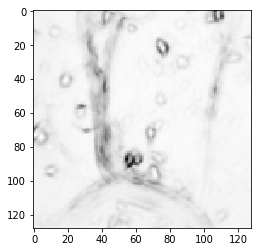

In [5]:
#%%
Yr,dims,T=cm.load_memmap(fname_new)
Y=np.reshape(Yr,dims+(T,),order='F')
#%% visualize correlation image
Cn = cm.local_correlations(Y)
pl.imshow(Cn,cmap='gray') 
pl.show()

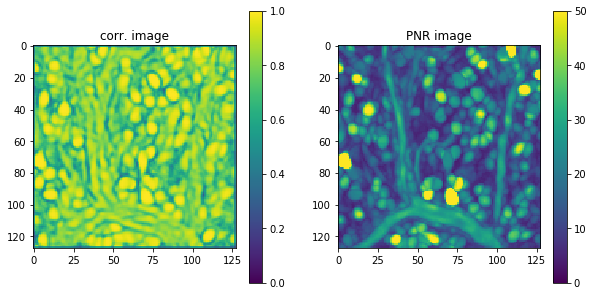

In [8]:
from caiman.summary_images import correlation_pnr_filtered
cn, pnr, _ = correlation_pnr_filtered(np.transpose(Y, [2,0,1]))
pl.figure(figsize=(10, 5))
pl.subplot(1,2,1)
pl.imshow(cn, vmin=0, vmax=1)
pl.colorbar()
pl.title('corr. image')
pl.subplot(1,2,2)
pl.imshow(pnr, vmin=0, vmax=50)
pl.colorbar()
pl.title('PNR image')

In [9]:
#%% parameters of experiment
K=[]     # number of neurons expected per patch
gSig=[3, 3]   # expected half size of neurons
gSiz = [10, 10]   # size of the gaussian kernel 
p=2 #order of the autoregressive system

options = cnmf.utilities.CNMFSetParms(Y
        ,n_processes,p=p,gSig=gSig,K=K,ssub=2,tsub=2, normalize_init=True)

using 4 processes
using 1000 pixels per process
using 1000 block_size


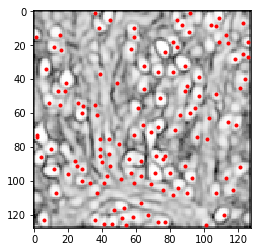

In [14]:
# from caiman.source_extraction.cnmf.initialization import greedyROI_corr
# Ain, Cin, C_raw, S, center, b, f = greedyROI_corr(Y, g_size=10, g_sig=3, min_corr=0.85, min_pnr=20)

pl.imshow(cn, cmap='gray')
pl.plot(center[0], center[1], '.r')

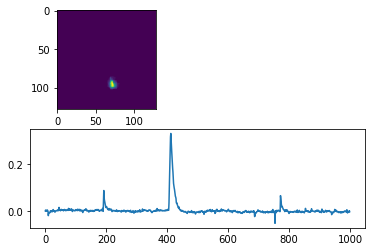

In [18]:
m = 1
pl.subplot(2,2,1)
pl.imshow(Ain[:, m].reshape(128, 128))
pl.subplot(2,1,2)
pl.plot(C_raw[m])

 CNMFSetParms define Dictionaries of CNMF parameters.
 Any parameter that is not set get a default value specified.
 
     each dictionnary is used by different part of the CNMF process : 
 - init_paramters
 - pre_processing_parameters
 - patch_parameters
 - spatial_parameters
 - temporal_parameters
    

<h2> Preprocessing of the datas and initialization of the components </h2>
<ul><li> here, we compute the mean of the noise spectral density </li>
<li> then, we initialize each component with a greedy ROI algorithm on component that have been spatially filter using a gaussian kernel </li>
<li> we then further update the component using Hals method on the newly obtained nmf paramters</ul>
<p> see More : NMF AND ROI :http://www.cell.com/neuron/fulltext/S0896-6273(15)01084-3<br\> </p>


In [ ]:
Yr,sn,g,psx = cnmf.pre_processing.preprocess_data(Yr
            ,dview=dview
            ,n_pixels_per_process=100,  noise_range = [0.25,0.5]
            ,noise_method = 'logmexp', compute_g=False,  p = 2,
             lags = 5, include_noise = False, pixels = None
            ,max_num_samples_fft=3000, check_nan = True)

Ain, Cin, b_in, f_in, center=cnmf.initialization.initialize_components(Y
            ,K=30, gSig=[5, 5], gSiz=None, ssub=1, tsub=1, nIter=5, maxIter=5, nb=1
            , use_hals=False, normalize_init=True, img=None, method='greedy_roi'
            , max_iter_snmf=500, alpha_snmf=10e2, sigma_smooth_snmf=(.5, .5, .5)
            , perc_baseline_snmf=20)
p1=nb_plot_contour(Cn,Ain,dims[0],dims[1],thr=0.9,face_color=None
                    , line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

<h2> HALS </h2>
we want to minimize
<img src=docs/img/hals1.png width=300px/>
updating parameters
<img src=docs/img/hals2.png width=300px />
<p>HALS : http://proceedings.mlr.press/v39/kimura14.pdf</p>


In [ ]:
Ain, Cin, b_in, f_in = cnmf.initialization.hals(Y, Ain, Cin, b_in, f_in, maxIter=5)
p1=nb_plot_contour(Cn,Ain,dims[0],dims[1],thr=0.9,face_color=None
                    , line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

In [ ]:
#%% UPDATE SPATIAL COMPONENTS
pl.close()
t1 = time()
A,b,Cin,f_in = cnmf.spatial.update_spatial_components(Yr, Cin, f_in, Ain, sn=sn, dview=dview,**options['spatial_params'])
t_elSPATIAL = time() - t1
print t_elSPATIAL 
#clear_output(wait=True)
print('DONE!')

In [ ]:
pl.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
crd = plot_contours(A,Cn,thr=0.9)
pl.show()

In [ ]:
p1=nb_plot_contour(Cn,A.todense(),dims[0],dims[1],thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

In [ ]:
pl.close()
t1 = time()
options['temporal_params']['p'] = 0 # set this to zero for fast updating without deconvolution
C,A,b,f,S,bl,c1,neurons_sn,g,YrA = cnmf.temporal.update_temporal_components(Yr,A,b,Cin,f_in,bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
t_elTEMPORAL = time() - t1
print t_elTEMPORAL  
clear_output(wait=True)

In [ ]:
#%% merge components corresponding to the same neuron
t1 = time()
A_m,C_m,nr_m,merged_ROIs,S_m,bl_m,c1_m,sn_m,g_m=cnmf.merging.merge_components(Yr,A,b,C,f,S,sn,options['temporal_params'], options['spatial_params'],dview=dview, bl=bl, c1=c1, sn=neurons_sn, g=g, thr=merge_thresh, mx=50, fast_merge = True)
t_elMERGE = time() - t1
print t_elMERGE

In [ ]:
#refine spatial and temporal components
pl.close()
t1 = time()
A2,b2,C2,f = cnmf.spatial.update_spatial_components(Yr, C_m, f, A_m, sn=sn,dview=dview, **options['spatial_params'])
options['temporal_params']['p'] = p # set it back to original value to perform full deconvolution
C2,A2,b2,f2,S2,bl2,c12,neurons_sn2,g21,YrA = cnmf.temporal.update_temporal_components(Yr,A2,b2,C2,f,dview=dview, bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
clear_output(wait=True)
print time() - t1 # 100 seconds
print('DONE!')

In [ ]:
tB = np.minimum(-2,np.floor(-5./30*final_frate))
tA = np.maximum(5,np.ceil(25./30*final_frate))
Npeaks=10
traces=C2+YrA
#        traces_a=traces-scipy.ndimage.percentile_filter(traces,8,size=[1,np.shape(traces)[-1]/5])
#        traces_b=np.diff(traces,axis=1)
fitness_raw, fitness_delta, erfc_raw, erfc_delta, r_values, significant_samples = \
    evaluate_components(Y, traces, A2, C2, b2, f2, final_frate, remove_baseline=True,
                                      N=5, robust_std=False, Athresh=0.1, Npeaks=Npeaks,  thresh_C=0.3)
    
idx_components_r=np.where(r_values>=.6)[0]
idx_components_raw=np.where(fitness_raw<-60)[0]        
idx_components_delta=np.where(fitness_delta<-20)[0]   


min_radius=gSig[0]-2
masks_ws,idx_blobs,idx_non_blobs=extract_binary_masks_blob(
A2.tocsc(), min_radius, dims, num_std_threshold=1, 
minCircularity= 0.6, minInertiaRatio = 0.2,minConvexity =.8)




idx_components=np.union1d(idx_components_r,idx_components_raw)
idx_components=np.union1d(idx_components,idx_components_delta)  
idx_blobs=np.intersect1d(idx_components,idx_blobs)   
idx_components_bad=np.setdiff1d(range(len(traces)),idx_components)
clear_output(wait=True)
print(' ***** ')
print len(traces)
print(len(idx_components))
print(len(idx_blobs))

In [ ]:
fg=pl.figure(figsize=(12,20))
pl.subplot(1,2,1)
crd = plot_contours(A2.tocsc()[:,idx_components],Cn,thr=0.9)
pl.subplot(1,2,2)
crd = plot_contours(A2.tocsc()[:,idx_components_bad],Cn,thr=0.9)
print(dims)

In [ ]:
p2=nb_plot_contour(Cn,A2.tocsc()[:,idx_components].todense(),dims[0],dims[1],thr=0.9,face_color='purple', line_color='black',alpha=0.3,line_width=2)
bpl.show(p2)

In [ ]:
discard_traces_fluo=nb_view_patches(Yr,A2.tocsc()[:,idx_components],C2[idx_components],b2,f2,dims[0],dims[1],thr = 0.8,image_neurons=Cn, denoised_color='red')

In [ ]:
discard_traces_fluo=nb_view_patches(Yr,A2.tocsc()[:,idx_components_bad],C2[idx_components_bad],b2,f2,dims[0],dims[1],thr = 0.8,image_neurons=Cn, denoised_color='red')

In [ ]:
#%% STOP CLUSTER
cm.stop_server()